In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import tensorflowjs as tfjs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [25]:
# Constants
BATCH_SIZE = 32
LR = 1e-4

In [26]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [27]:
def process_match(match):
    champs = match.split(',')
    vec = []
    for i in range(10):
        champ_vec = get_champ_vec(champs[i])
        for e in champ_vec:
            vec.append(e)
    if champs[10] == 'true':
        vec.append(1)
    else:
        vec.append(0)
    return vec

In [28]:
def process_ds_element(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'int32'))

In [29]:
def get_dataset(num_games):
    tmp = []
    with open('data/matches/diamond_training_data.txt', 'r') as f:
        matches = f.read().split('\n')
        num_games = min(len(matches), num_games)
        for i in range(num_games):
            try:
                tmp.append(process_match(matches[i]))
            except:
                num_games -= 1
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_ds_element)
    ds = ds.cache()
    ds = ds.shuffle(num_games)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    print(f'Using {num_games} matches for training')
    return ds

In [21]:
ds = get_dataset(10000)

Using 10000 matches for training


In [30]:
# Partition Dataset
train_size = int(len(ds)*0.8)
val_size = int(len(ds)*0.1)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)
print(train_size, val_size, test_size)

250 31 32


In [37]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=170))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [38]:
model = create_model()

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               21888     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [40]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [41]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
250/250 [==============================] - 0s 968us/step - loss: 0.6965 - binary_accuracy: 0.5016 - val_loss: 0.6919 - val_binary_accuracy: 0.5222
Epoch 2/100
250/250 [==============================] - 0s 771us/step - loss: 0.6931 - binary_accuracy: 0.5196 - val_loss: 0.6926 - val_binary_accuracy: 0.5212
Epoch 3/100
250/250 [==============================] - 0s 803us/step - loss: 0.6905 - binary_accuracy: 0.5281 - val_loss: 0.6825 - val_binary_accuracy: 0.5635
Epoch 4/100
250/250 [==============================] - 0s 783us/step - loss: 0.6888 - binary_accuracy: 0.5357 - val_loss: 0.6908 - val_binary_accuracy: 0.5312
Epoch 5/100
250/250 [==============================] - 0s 771us/step - loss: 0.6890 - binary_accuracy: 0.5403 - val_loss: 0.6857 - val_binary_accuracy: 0.5534
Epoch 6/100
250/250 [==============================] - 0s 763us/step - loss: 0.6868 - binary_accuracy: 0.5499 - val_loss: 0.6845 - val_binary_accuracy: 0.5726
Epoch 7/100
250/250 [=========================

250/250 [==============================] - 0s 791us/step - loss: 0.5290 - binary_accuracy: 0.7475 - val_loss: 0.5235 - val_binary_accuracy: 0.7460
Epoch 53/100
250/250 [==============================] - 0s 763us/step - loss: 0.5174 - binary_accuracy: 0.7604 - val_loss: 0.5167 - val_binary_accuracy: 0.7722
Epoch 54/100
250/250 [==============================] - 0s 787us/step - loss: 0.5161 - binary_accuracy: 0.7606 - val_loss: 0.5001 - val_binary_accuracy: 0.7611
Epoch 55/100
250/250 [==============================] - 0s 775us/step - loss: 0.5118 - binary_accuracy: 0.7584 - val_loss: 0.5079 - val_binary_accuracy: 0.7692
Epoch 56/100
250/250 [==============================] - 0s 775us/step - loss: 0.5056 - binary_accuracy: 0.7654 - val_loss: 0.5044 - val_binary_accuracy: 0.7772
Epoch 57/100
250/250 [==============================] - 0s 771us/step - loss: 0.4984 - binary_accuracy: 0.7695 - val_loss: 0.4912 - val_binary_accuracy: 0.7853
Epoch 58/100
250/250 [==============================]

In [43]:
history_dict = history.history

In [44]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

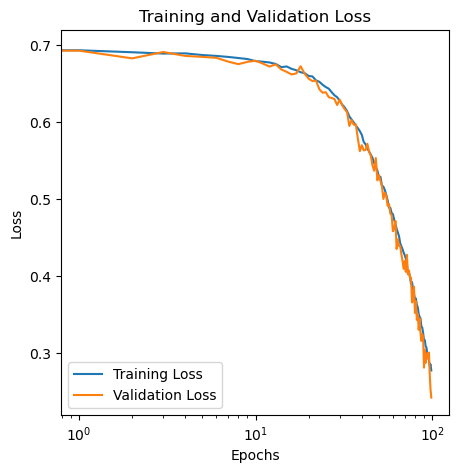

In [45]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

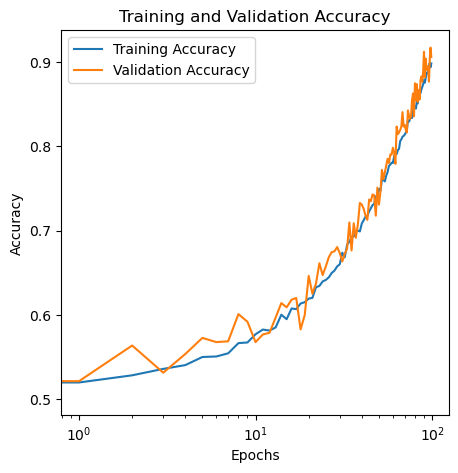

In [46]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

32/32 [==============================] - 0s 516us/step - loss: 0.2741 - binary_accuracy: 0.9067
Loss: 0.27406951785087585
Accuracy: 0.9067460298538208


In [ ]:
# Save the model
export_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Activation('sigmoid')
])

In [36]:
tfjs.converters.save_keras_model(export_model, 'winpredictor/public/models/master')